# Multiple Observations: joint and hierarchical calibration
## Part 1: Joint Calibration with Sepia
This notebook will show a simple example of some issues that can
arise when calibrating against multiple data instances that can be
interpreted as having conflict in the information they convey
with respect to the model. That is, different observations suggest
different parameter settings. Here, for purposes of demonstration,
discrepancy models will not be considered as a solution.

This notebook continues with the example code in the linear_response_example.ipynb
observation_error_example.ipynb notebooks.

Read in modeling and plotting functions. The main function here
facilitates setting and fixing various model parameters. In this case,
fixing the parameters that correspond to a linear emulator response and
observation error adjustment.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sepia import SepiaData, SepiaModel, SepiaPlot, \
    SepiaEmulatorPrediction, SepiaFullPrediction, \
    SepiaHierarchicalThetaModels

def run_model(m=4, obs=[2.5], Sigy=0.1, disable_lamOS=True, setup_only=False):
    t_sim=np.linspace(1,4,m).reshape((-1,1))
    y_sim=np.linspace(4,1,m).reshape((-1,1))
    y_obs=np.array(obs).reshape((-1,1))

    dat = SepiaData(t_sim=t_sim, y_sim=y_sim, y_obs=y_obs, Sigy=Sigy)
    dat.standardize_y()
    dat.transform_xt()

    mod=SepiaModel(dat)

    # Change default sepia model parameter based
    # on flags/values passed in.
    if disable_lamOS:
        # Scaling of observation error
        mod.set_param('lamOs',fix=1)
    #fix other parameters to allow a highly-certain linear response emulator
    # Process precision - so it's not forcing N(0,1) marginal response locally
    mod.set_param('lamUz',fix=0.01)
    # Nugget / noise process variance for simulations = near-zero variance
    mod.set_param('lamWs',fix=1e6)
    # Scaling of simulator error = near-zero variance
    # (which is relevant to allocating relative uncertainty for multivariate response)
    mod.set_param('lamWOs',fix=1e6)

    if setup_only:
        # don't do any sampling
        return mod

    # "fit" the model by generating posterior samples
    mod.do_mcmc(100)  # go past transient
    mod.clear_samples()
    mod.do_mcmc(5000) # collect samples

    return mod

def plot_trace(mod):
    #call the trace plot built-in with the samples
    samp=mod.get_samples()
    SepiaPlot.mcmc_trace(samp)
    plt.show()

def plot_cal(mod):
    # plot the calibration setup and results
    psamp=mod.get_samples(numsamples=500)
    t_pred=np.linspace(0,5,50).reshape((-1,1))
    spred=SepiaEmulatorPrediction(t_pred=t_pred, model=mod, samples=psamp)
    ysp=spred.get_y()
    yspm=np.mean(ysp,axis=0).squeeze()
    ysps=np.std(ysp,axis=0).squeeze()

    opred=SepiaFullPrediction(model=mod,samples=psamp)
    yop=opred.get_yobs()

    fig,ax1 = plt.subplots()
    ax1.plot(t_pred,yspm,'k')
    ax1.plot(t_pred,yspm+2*ysps,'k.')
    ax1.plot(t_pred,yspm-2*ysps,'k.')
    ax1.plot(mod.data.sim_data.t,mod.data.sim_data.y,'go')
    ax1.plot(psamp['theta_native'],yop.squeeze(),'r.')
    calx=np.array([0,5]).reshape((-1,1))
    ax1.plot(calx,np.ones((2,1))*mod.data.obs_data.y,'b')
    ax1.plot(calx,np.ones((2,1))*(mod.data.obs_data.y+2*np.sqrt(mod.data.obs_data.Sigy)),'b:')
    ax1.plot(calx,np.ones((2,1))*(mod.data.obs_data.y-2*np.sqrt(mod.data.obs_data.Sigy)),'b:')
    ax2=ax1.twinx()
    sns.histplot(psamp['theta_native'],kde=True,color='r',ax=ax2,legend=False)
    ax2.set_ylabel(''); ax2.set_yticks([]); ax2.set_ybound([i*5 for i in ax2.get_ybound()])
    plt.show()

    samp=mod.get_samples()
    theta_std=np.std(samp['theta_native'],ddof=1)
    print('Theta std = %f, var = %f'%(theta_std,theta_std**2))


See the observation_error_example for more detail on the settings and use of this
function, as well as how to control the observation error. The function is expanded
here to handle multiple observations, but is very similar. This example will not
dwell on sampling, but rather will just look at calibration results.

We start with a basic example of calibration of an observation at 2.5 with
observation error variance = 0.1.

MCMC sampling: 100%|██████████| 5000/5000 [00:06<00:00, 826.64it/s]


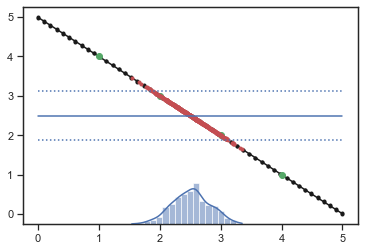

Theta std = 0.310155, var = 0.096196


In [2]:
mod=run_model()

plot_cal(mod)

The plot shows an emulator's response in black, fit to data in green. Observation mean
and +/- 2 s.d. are blue lines, and the sampled posterior distribution is in the histogram.

Now we will calibrate with two observations, at values of 2 and 3. Individually, they would
result in plots as above, with their individually determined posterior histograms shown below.

MCMC sampling: 100%|██████████| 5000/5000 [00:05<00:00, 843.08it/s]


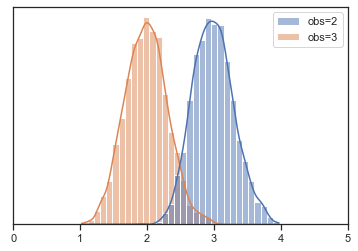

In [3]:
mod2=run_model(obs=2)
mod3=run_model(obs=3)

#Collect the posterior theta values from each
theta23_individual=np.hstack((mod2.get_samples()['theta_native'],
                              mod3.get_samples()['theta_native']))

ax23=sns.histplot(pd.DataFrame(theta23_individual,columns=['obs=2','obs=3']),kde=True)
ax23.set(xlim=[0,5])
ax23.set_ylabel(''); ax23.set_yticks([]);

As expected, calibrating with the two different observations are values of 2 and 3 result in
distinct posteriors.

Next, we can see what happens if we calibrate to the two observations simultaneously; we will refer
to this as *joint* calibration:

MCMC sampling: 100%|██████████| 5000/5000 [00:06<00:00, 775.18it/s]


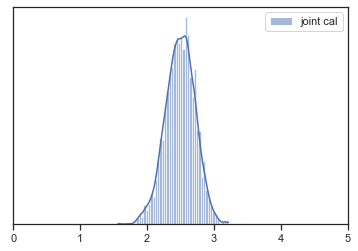

In [4]:
mod_joint=run_model(obs=[2,3])

axj=sns.histplot(pd.DataFrame(mod_joint.get_samples()['theta_native'],columns=['joint cal']),kde=True)
axj.set(xlim=[0,5])
axj.set_ylabel(''); axj.set_yticks([]);


This result is explained by the plot above showing the two histograms. The likelihood of the
posterior is equivalent to the *product* of the two individual likelihoods. In this simple
linear problem, the resulting calibration is the product
of the two posteriors.

Putting this data together in a model leads to a well-defined posterior. What can't be seen here in
sampling of the posterior distribution without normalization is
that this posterior is low likelihood: predictions from this posterior won't
agree well with the data. The danger is
that this is not easily observed without diligent examination as we've done here, looking at the
individual calibration results as well as the joint calibration result.

One solution to this is to allow the observation error to increase. In the observation_error_example
notebook the effect of a parameter to do just this was shown - this parameter was called $lamOs$, and
$1/lamOs$ multiplies the value of Sigy. In the above example we fixed $lamOs$ to 1, but if we allow it
to be varied to maximize the posterior, we end up with a posterior calibration:

MCMC sampling: 100%|██████████| 5000/5000 [00:07<00:00, 703.08it/s]


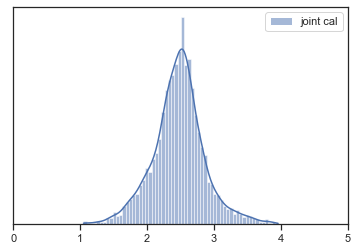

In [5]:
mod_joint_with_lamOs=run_model(obs=[2,3], disable_lamOS=False)

axjwl=sns.histplot(pd.DataFrame(mod_joint_with_lamOs.get_samples()['theta_native'],columns=['joint cal']),kde=True)
axjwl.set(xlim=[0,5])
axjwl.set_ylabel(''); axjwl.set_yticks([]);

To explain this result, we can look at the posterior value for $lamOs$:

In [6]:
print(np.mean(mod_joint_with_lamOs.get_samples()['lamOs'][1000:]))

0.6055634515548666


This reveals is that the posterior is maximized with a $lamOs$ value that
scales the observation error to be closer to an s.d. of 1 than an s.d. of 0.01.
This does make a more sensible posterior, as there is a feasible solution with that
effective observation error that includes both observations. In the observation_error_example,
this worked the opposite way: because the single observation was consistent with the
emulator, the effective observation error would tend to get smaller.

Note that although this is somewhat successful in this case, it is not a panacea for more complex
cases with non-linear responses, structured discrepancy, and multivariate observations.

## Part 2: Hierarchical calibration
There is another approach that we call *hierarchical* calibration. Hierarchical
calibration is a combination of the above analyses: It calibrates a parameter
posterior for each observation (or subset of observations), but models these
parameters as being from a Normal distribution with a prior of low variance.
This allows the parameters to be different, and the posterior distribution our
example then contains both these parameter posterior distributions.

---
We will start with constructing the independent models used above, but not sampling them.

The hierarchical model encompasses these two models, plus an array that makes
the correspondence between the variables. In this case that's simple, there is one parameter
in each model, and we'll correspond those.

In [7]:
mod2h=run_model(obs=2,setup_only=True,Sigy=0.1)
mod3h=run_model(obs=3,setup_only=True,Sigy=0.1)
mod_hier = SepiaHierarchicalThetaModels([mod2h, mod3h], np.array([[0, 0]]))

With the hierarchical model set up, do some mcmc sampling akin to a single model.
The hierarchical model samples all of the member models as well as the hierarchical
distribution.

In [8]:
mod_hier.do_mcmc(5000)

MCMC sampling:   0%|          | 0/5000 [00:00<?, ?it/s]/Users/gatt/Work/projects/saf/sepia/sepia/SepiaHierarchicalThetaModels.py:248: RuntimeWarning: divide by zero encountered in log
  if np.log(np.random.uniform()) < (np.sum(new_prior) - np.sum(old_prior) + np.log(hprm.mcmc.aCorr)):
MCMC sampling: 100%|██████████| 5000/5000 [00:33<00:00, 147.77it/s]


The hierarchical model samples all of the member models as well as the hierarchical
distribution, so look at the parameter distributions of the two models.

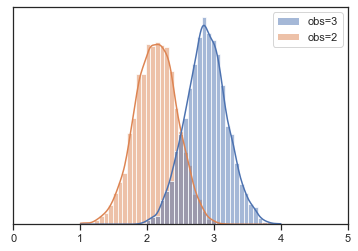

In [9]:
samp_hier=mod_hier.get_samples()
samp2h=samp_hier['model0']
samp3h=samp_hier['model1']

theta23_hier=np.hstack((samp2h['theta_native'],samp3h['theta_native']))

ax23h=sns.histplot(pd.DataFrame(theta23_hier,columns=['obs=3','obs=2']),kde=True)
ax23h.set(xlim=[0,5]); ax23h.set_ylabel(''); ax23h.set_yticks([]);

Now, we look at the hierarchical model's parameter calibrations.

Mean:  DescribeResult(nobs=5000, minmax=(array([0.00158575]), array([0.99818769])), mean=array([0.5179411]), variance=array([0.03586481]), skewness=array([-0.08797896]), kurtosis=array([0.04934124]))
Std:   DescribeResult(nobs=5000, minmax=(array([0.02036723]), array([16.12722756])), mean=array([0.37498087]), variance=array([0.43294112]), skewness=array([10.5164182]), kurtosis=array([175.51457571]))


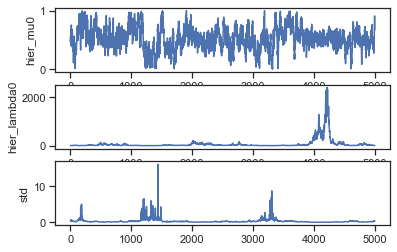

In [10]:
plt.figure()
hpar_names=['hier_mu0','hier_lambda0']
for ii in range(2):
    plt.subplot(3,1,ii+1)
    plt.plot(samp_hier[hpar_names[ii]])
    plt.ylabel(hpar_names[ii])
plt.subplot(3,1,3)
plt.plot(1/np.sqrt(samp_hier['hier_lambda0']))
plt.ylabel('std')
import scipy as sp
print('Mean: ',sp.stats.describe(samp_hier['hier_mu0']))
print('Std:  ',sp.stats.describe(1/np.sqrt(samp_hier['hier_lambda0'])))

Text(0.5, 1.0, 'Hierarchical distribution for theta')

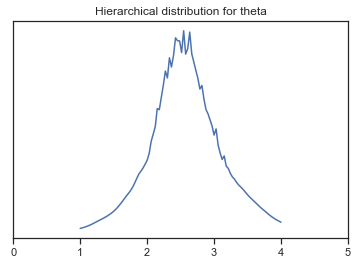

In [11]:
# add the normal mixture up over a grid
x1=np.linspace(0,1,100)
hy=np.zeros(len(x1))
for ii in range(5000):
    hy=hy+sp.stats.norm.pdf(x1,loc=samp_hier['hier_mu0'][ii,0],
                           scale=1/samp_hier['hier_lambda0'][ii,0] )
#retrieve the x range info; the model will have been rescaled to [0,1]
xmin=mod2h.data.sim_data.orig_t_min[0]
xmax=mod2h.data.sim_data.orig_t_max[0]

plt.plot(x1*(xmax-xmin)+xmin,hy)
axh=plt.gca()
axh.set(xlim=[0,5])
axh.set_ylabel(''); axh.set_yticks([]);
plt.title('Hierarchical distribution for theta')

The hierarchical posterior summary is a sum of samples Gaussian
distributions. The plot may show spikes, because some of the
Gaussian distributions sampled can have very low variance. It only
takes a small number of these in the large number of sampled
distributions to introduce some jaggedness to the summary. For
display purposes, it would be sensible to introduce a small, but not
tiny, lower limit for the purposes of the plots.

Because we know
that the data cannot be reconciled with a single parameter
calibration, the hierarchical model comes out to be a more
reasonable posterior uncertainty, particularly compared to the
over-certain 'product-likelihood' analysis. The distribution covers the
distributions of the individual theta values.


### Hierarchical calibration without conflicting observations
This section  set up a hierarchical model with two models of consistent data,
with an identical treatment to that directly above.
The easiest way to do this is to use two models each with an
observation at 2.5. Each model is the same as the single model in the first
example in this notebook.

In [12]:
mod25a=run_model(setup_only=True)
mod25b=run_model(setup_only=True)
mod25h = SepiaHierarchicalThetaModels([mod25a, mod25b], np.array([[0, 0]]))

mod25h.do_mcmc(5000)

MCMC sampling:   0%|          | 0/5000 [00:00<?, ?it/s]/Users/gatt/Work/projects/saf/sepia/sepia/SepiaHierarchicalThetaModels.py:248: RuntimeWarning: divide by zero encountered in log
  if np.log(np.random.uniform()) < (np.sum(new_prior) - np.sum(old_prior) + np.log(hprm.mcmc.aCorr)):
MCMC sampling: 100%|██████████| 5000/5000 [00:32<00:00, 155.50it/s]


Mean:  DescribeResult(nobs=5000, minmax=(array([0.03057916]), array([0.99994566])), mean=array([0.51467366]), variance=array([0.01598109]), skewness=array([0.3287216]), kurtosis=array([1.73218187]))
Std:   DescribeResult(nobs=5000, minmax=(array([0.01930713]), array([6.65879983])), mean=array([0.13623762]), variance=array([0.06197107]), skewness=array([12.30148285]), kurtosis=array([250.98432938]))


Text(0.5, 1.0, 'Hierarchical distribution for theta')

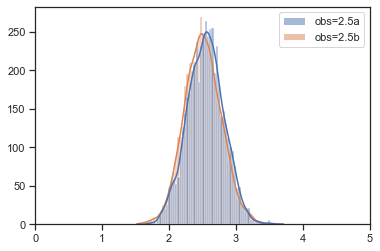

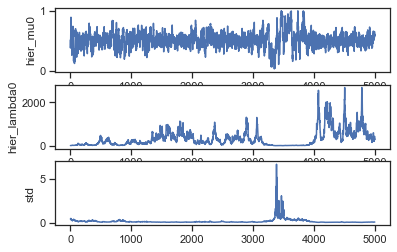

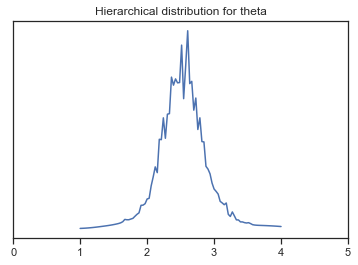

In [13]:
samp25h=mod25h.get_samples()
samp25a=samp25h['model0']
samp25b=samp25h['model1']

theta25h=np.hstack((samp25a['theta_native'],samp25b['theta_native']))

ax25h=sns.histplot(pd.DataFrame(theta25h,columns=['obs=2.5a','obs=2.5b']),kde=True)
ax25h.set(xlim=[0,5]); ax25h.set_ylabel(''); ax23h.set_yticks([])

plt.figure()
hpar_names=['hier_mu0','hier_lambda0']
for ii in range(2):
    plt.subplot(3,1,ii+1)
    plt.plot(samp25h[hpar_names[ii]])
    plt.ylabel(hpar_names[ii])
plt.subplot(3,1,3)
plt.plot(1/np.sqrt(samp25h['hier_lambda0']))
plt.ylabel('std')
import scipy as sp
print('Mean: ',sp.stats.describe(samp25h['hier_mu0']))
print('Std:  ',sp.stats.describe(1/np.sqrt(samp25h['hier_lambda0'])))


# add the normal mixture up over a grid
x1=np.linspace(0,1,100)
hy=np.zeros(len(x1))
for ii in range(5000):
    hy=hy+sp.stats.norm.pdf(x1,loc=samp25h['hier_mu0'][ii,0],
                           scale=1/samp25h['hier_lambda0'][ii,0] )
#retrieve the x range info; the model will have been rescaled to [0,1]
xmin=mod25a.data.sim_data.orig_t_min[0]
xmax=mod25a.data.sim_data.orig_t_max[0]

plt.figure()
plt.plot(x1*(xmax-xmin)+xmin,hy)
axh=plt.gca()
axh.set(xlim=[0,5])
axh.set_ylabel(''); axh.set_yticks([]);
plt.title('Hierarchical distribution for theta')

In this case, the two calibration distributions are identical, and
the hierarchcal distribution has shrunk to virtually the same as the
underlying distributions; there will be some uncertainty in that, so it is
expected to be slightly wider with slightly wider tails.

# Conclusion
Hierarchical parameter calibration provides an approach to modeling
data when it is anticipated that the observations show some conflict,
in the sense that a single calibration distribution does not
adequately summarize the data. This notebook has shown the danger
in this situation, when a single posterior is modeled, it can be
inappropriately over-certain.

The hierarchical model provides a diagnostic of the differences in the data,
showing whether the parameter posteriors w.r.t. different observations are
consistent or distinct. It also provides a posterior of the hierarchical
distribution that shows a more defensible uncertainty, both in the cases
of (with respect to the model and parameter calibration)
conflict between observations and agreement between observations.